In [214]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction

import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [215]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="adam", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         #learning_rate = "adaptive",
                         tol=1e-20) #default tolerance
    model.fit(X_train, y_train)
    return model

In [216]:
past_weeks = 4
hidden_layers = (3,3)
nRowsRead = None
grid_number = 1

df = pd.read_pickle('forecast1.pkl')

def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def to_string(date):
    return datetime.strftime(date, "%Y-%m-%d %H:%M:%S")


In [217]:
df['residuals'].size

12902

In [218]:
def data_ANN(past_weeks, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]

    X = []
    y = []
    
    for i in tqdm(range(len(residuals.values) - past_weeks*24*7)):
        X_el = residuals[i:i+24*7*past_weeks:24*7]
        X.append(X_el)
        y.append([residuals.iloc[i+past_weeks*24*7]])
    
    return X, y


In [219]:
X, y = data_ANN(past_weeks, df)

100%|██████████| 12230/12230 [00:00<00:00, 21570.27it/s]


In [220]:
train_size_percentage = 0.50

train_size = int(len(X)*train_size_percentage)
#print(len(data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number))/(24*7))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [221]:
model = ANN_train(X_train, y_train, hidden_layers)

In [222]:
def ANN_pred(model, X_test,X,y):
    X_test = X_test.copy()
    y_test = []
    for i in tqdm(range(len(X_test))):
        X_test_el = X_test[i].values
        val = model.predict(X_test_el.reshape(1,-1))
        y_test.append(val[0])
        if i%23==0 and i < len(X_test)-24:
            model.partial_fit(X[train_size+i:train_size+i+24], y[train_size+i:train_size+i+24])
    return y_test



In [223]:
y_pred = ANN_pred(model, X_test,X,y)

100%|██████████| 6115/6115 [00:01<00:00, 5991.26it/s]


In [224]:
temp = df.copy()
temp['pred_residuals'] = np.nan
temp['pred_residuals'].iloc[-len(y_pred):] = y_pred
#(temp['residuals']-temp['pred_residuals']).dropna().hist()

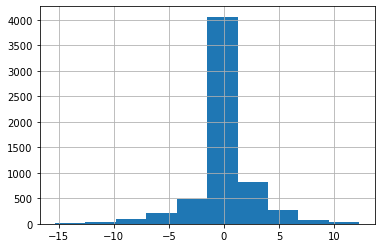

In [225]:
temp["pred_residuals"].hist()

In [226]:
df_from_ANN = pd.read_pickle('ANN_alone_forecast.pkl')

In [227]:
df_from_ANN

,grid1-loss,pred,diff,ann_sum_error,ann_cumsum
2019-12-01 00:00:00,21.55210,22.686309,-1.134209,1.134209,1.134209
2019-12-01 01:00:00,20.71190,21.595508,-0.883608,0.883608,2.017817
2019-12-01 02:00:00,20.27340,20.773316,-0.499916,0.499916,2.517733
2019-12-01 03:00:00,20.25370,20.443139,-0.189439,0.189439,2.707172
2019-12-01 04:00:00,20.40550,20.209076,0.196424,0.196424,2.903596
...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,13.035968,-4.476168,4.476168,22534.680531
2020-05-30 20:00:00,6.95209,12.870605,-5.918515,5.918515,22540.599047
2020-05-30 21:00:00,8.11558,12.926121,-4.810541,4.810541,22545.409588
2020-05-30 23:00:00,7.26431,12.561953,-5.297643,5.297643,22550.707231


In [228]:
temp = temp.dropna()

temp['Hybrid'] = temp['ARIMA']+temp['pred_residuals']
temp['ANN'] = df_from_ANN['pred']

temp['arima_sum_error'] = abs(temp['grid-loss'] - temp['ARIMA'])
temp['hybrid_sum_error'] = abs(temp['grid-loss'] - temp['Hybrid'])
temp['ann_sum_error'] = df_from_ANN['ann_sum_error']

temp['arima_cumsum'] = temp['arima_sum_error'].cumsum()
temp['hybrid_cumsum'] = temp['hybrid_sum_error'].cumsum()
temp['error_in_res'] = (temp['residuals']-temp['pred_residuals'])
temp['ann_cumsum'] = df_from_ANN['ann_sum_error'].iloc[-train_size:].cumsum()

In [229]:
temp['grid-loss'].min()
temp.index = [to_datetime(string) for string in temp.index]

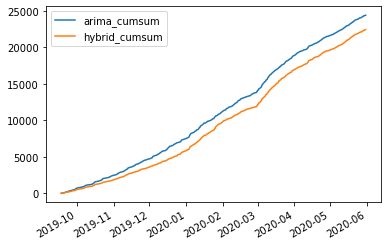

In [230]:
temp[['arima_cumsum','hybrid_cumsum']].iloc[:].plot()


In [231]:
(temp['arima_cumsum'].iloc[-1]-temp['hybrid_cumsum'].iloc[-1])/temp['arima_cumsum'].iloc[-1]

0.08075061293816439

In [232]:
diff = temp['grid-loss']-temp['Hybrid']
mse_hybrid = (diff**2).mean()

In [233]:
diff = temp['grid-loss']-temp['ARIMA']
mse_arima = (diff**2).mean()



In [234]:
(mse_arima-mse_hybrid)/mse_arima

0.12642170595675065

In [114]:
abs(temp['error_in_res']).cumsum()

2019-10-19 08:00:00        0.145961
2019-10-19 09:00:00        0.656815
2019-10-19 10:00:00        0.945262
2019-10-19 11:00:00        1.053622
2019-10-19 12:00:00        2.057389
                           ...     
2020-05-30 19:00:00    22703.739228
2020-05-30 20:00:00    22704.038170
2020-05-30 21:00:00    22705.423609
2020-05-30 23:00:00    22709.884834
2020-05-31 00:00:00    22712.576567
Name: error_in_res, Length: 5359, dtype: float64

In [115]:
temp.index = [to_datetime(string) for string in temp.index]

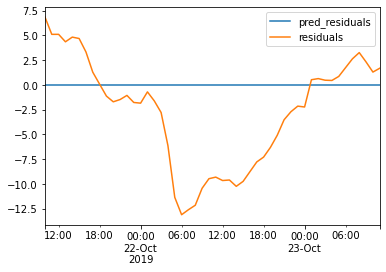

In [116]:
temp[['pred_residuals','residuals']].iloc[50:100].plot()

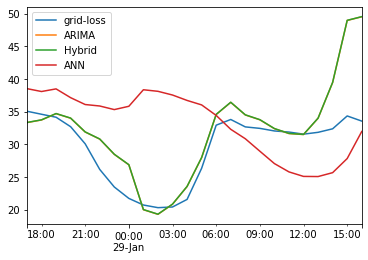

In [117]:
temp[['grid-loss','ARIMA', 'Hybrid', 'ANN']].iloc[2400:2424].plot()

In [46]:
mse = sum([temp['grid-loss']-temp['Hybrid']])

In [236]:
temp[['Hybrid', 'pred_residuals']].to_pickle('ANN_in_hybrid_forecast.pkl')

In [235]:
temp

,grid-loss,ARIMA,residuals,pred_residuals,Hybrid,ANN,arima_sum_error,hybrid_sum_error,ann_sum_error,arima_cumsum,hybrid_cumsum,error_in_res,ann_cumsum
2019-09-17 20:00:00,15.23740,17.894140,-2.656740,-0.900096,16.994044,NaN,2.656740,1.756644,NaN,2.656740,1.756644,-1.756644,NaN
2019-09-17 21:00:00,13.20070,15.633927,-2.433227,-0.219159,15.414768,NaN,2.433227,2.214068,NaN,5.089967,3.970712,-2.214068,NaN
2019-09-17 22:00:00,11.59470,14.029514,-2.434814,-0.028028,14.001486,NaN,2.434814,2.406786,NaN,7.524780,6.377498,-2.406786,NaN
2019-09-17 23:00:00,10.71090,13.231901,-2.521001,-0.141197,13.090704,NaN,2.521001,2.379804,NaN,10.045781,8.757302,-2.379804,NaN
2019-09-18 00:00:00,10.39860,12.977387,-2.578787,-0.308097,12.669291,NaN,2.578787,2.270691,NaN,12.624568,11.027992,-2.270691,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,7.594048,0.965752,-0.024951,7.569097,13.035968,0.965752,0.990703,4.476168,24387.079907,22416.337404,0.990703,22534.680531
2020-05-30 20:00:00,6.95209,7.230576,-0.278486,-0.024951,7.205625,12.870605,0.278486,0.253535,5.918515,24387.358392,22416.590939,-0.253535,22540.599047
2020-05-30 21:00:00,8.11558,9.480563,-1.364983,-0.985221,8.495342,12.926121,1.364983,0.379762,4.810541,24388.723375,22416.970701,-0.379762,22545.409588
2020-05-30 23:00:00,7.26431,11.705078,-4.440768,1.798962,13.504040,12.561953,4.440768,6.239730,5.297643,24393.164144,22423.210431,-6.239730,22550.707231
